In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

csvPath = "../data/"
file1 = "Beijing_housing_price.csv"
file2 = "kc_house_data.csv"

df_beijing      = pd.DataFrame(pd.read_csv(csvPath + file1))
df_kc           = pd.DataFrame(pd.read_csv(csvPath + file2)) 
df_kc['unit_price'] = df_kc['price'] / (df_kc['sqft_lot15']+df_kc['sqft_living15']+df_kc['sqft_living']+df_kc['sqft_lot']+df_kc['sqft_above']+df_kc['sqft_basement'])


# Visualization
(1) pick some feature that seems meaningful and show some data points

(2) compare Beijing and KC

# Beijing

clustering and visualization by geographic location, only use a subset of the data

In [2]:
print(df_beijing.head())
df_beijing_subset = df_beijing[['Lng','Lat', 'price']].iloc[0:500,:].copy()

          Lng        Lat tradeTime   DOM  followers  totalPrice  price  \
0  116.475489  40.019520    8/9/16  1464        106       415.0  31680   
1  116.453917  39.881534   7/28/16   903        126       575.0  43436   
2  116.561978  39.877145  12/11/16  1271         48      1030.0  52021   
3  116.438010  40.076114   9/30/16   965        138       297.5  22202   
4  116.428392  39.886229   8/28/16   927        286       392.0  48396   

   square  livingRoom  drawingRoom  ...  buildingType  constructionTime  \
0  131.00           2            1  ...             1              2005   
1  132.38           2            2  ...             1              2004   
2  198.00           3            2  ...             4              2005   
3  134.00           3            1  ...             1              2008   
4   81.00           2            1  ...             4              1960   

   renovationCondition  buildingStructure  ladderRatio  elevator  \
0                    3              

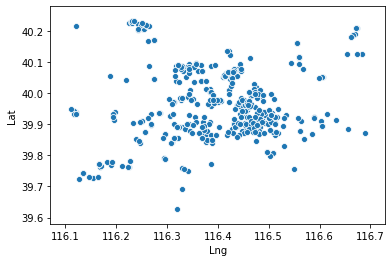

In [3]:
ax = sns.scatterplot(x='Lng', y='Lat', data=df_beijing_subset)

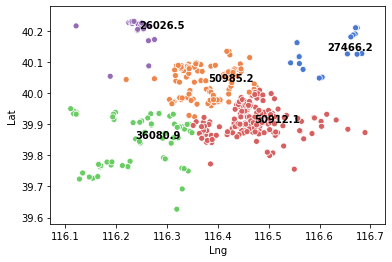

In [4]:
from sklearn.cluster import KMeans
CONST_n_clusters = 5
KMC = KMeans(n_clusters = CONST_n_clusters)
KMC.fit(df_beijing_subset[['Lng','Lat']])
KMC_pred = KMC.predict(df_beijing_subset[['Lng','Lat']])
df_beijing_subset['cluster'] = KMC_pred 
ax = sns.scatterplot(x='Lng', y='Lat', hue='cluster', 
                     palette=sns.color_palette("muted", n_colors=CONST_n_clusters), 
                     legend = False,
                     data=df_beijing_subset)
for i in df_beijing_subset['cluster'].unique():
    df_average = df_beijing_subset[df_beijing_subset['cluster'] == i].mean()
    ax.text(df_average.iloc[0], df_average.iloc[1], str(df_average.iloc[2].round(1)), 
            horizontalalignment='left', size='medium', weight='semibold')

This is very interesting and promising! 
We know that the location is a key fact of housing price, and the central area of Beijing is the most expensive region in the city. We can easily find that the average price (per square) of all clusters drops when the cluster goes away from the center of the fig, so the result is consistent to our knowledge.

We can also see that the average price differs a lot, which means we might want to consider using different predictor to predict the housing price for each cluster.


## Model: K-means

As shown before, it's a little tricky how to choose the number of clusters when using K-means. Here we trial and error and find that 13 might be a good number as it clustering the data in the way:

(1) the clustering result is similar to actual district in Beijing.

(2) the average price varies a lot even the clusters are geographically next to each other.




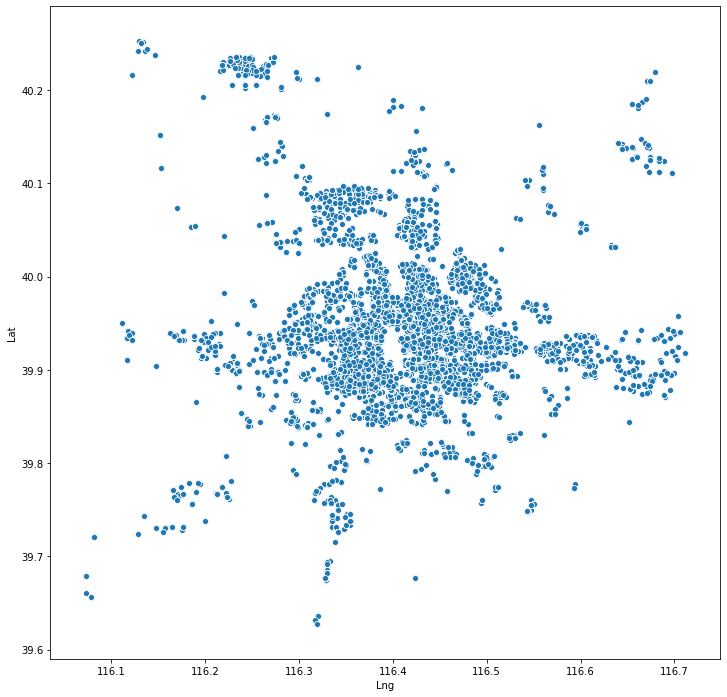

In [5]:
plt.figure(figsize=(12, 12))
ax = sns.scatterplot(x='Lng', y='Lat', data=df_beijing)

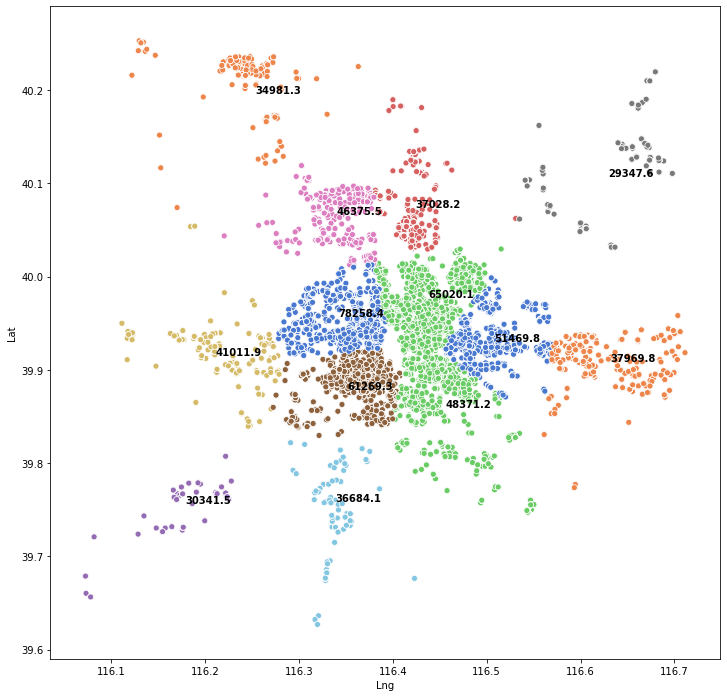

In [6]:
N_clusters = 13
KMC_beijing = KMeans(n_clusters = N_clusters)
KMC_beijing.fit(df_beijing[['Lng','Lat']])
KMC_beijing_pred = KMC_beijing.predict(df_beijing[['Lng','Lat']])
df_beijing['cluster'] = KMC_beijing_pred  

plt.figure(figsize=(12, 12))

ax = sns.scatterplot(x='Lng', y='Lat', hue='cluster', 
                     palette=sns.color_palette("muted", n_colors=N_clusters), 
                     legend = False,
                     data=df_beijing)
for i in df_beijing['cluster'].unique():
    df_average = df_beijing[df_beijing['cluster'] == i].mean()
    ax.text(df_average['Lng'], df_average['Lat'], str(df_average['price'].round(1)), 
            horizontalalignment='left', size='medium', weight='semibold')
# plt.savefig('Beijing_KM.png',dpi=600) 

This is extremely interesting, because (1) the adjacent clusters have very different mean price, which supports our assumption the sale prices of housing in different regions might have different distribution, so that we might want to train seperate models to predict the price. (2) the clusters are very similar to the geographic district of Beijing.

## Model: Birch

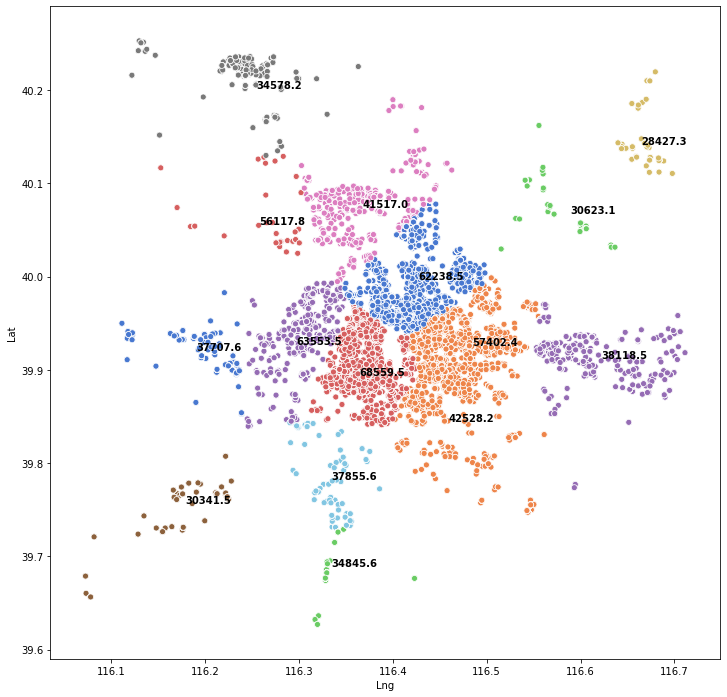

In [7]:
from sklearn.cluster import Birch
MSC_beijing = Birch(branching_factor=50, n_clusters=None, threshold=0.06, compute_labels=True)
MSC_beijing.fit(df_beijing[['Lng','Lat']])
MSC_beijing_pred = MSC_beijing.predict(df_beijing[['Lng','Lat']])
df_beijing['cluster1'] = MSC_beijing_pred  

plt.figure(figsize=(12, 12))

ax = sns.scatterplot(x='Lng', y='Lat', hue='cluster1', 
                     palette=sns.color_palette("muted", n_colors=len(df_beijing['cluster1'].unique())), 
                     legend = False,
                     data=df_beijing)
for i in df_beijing['cluster1'].unique():
    df_average = df_beijing[df_beijing['cluster1'] == i].mean()
    ax.text(df_average['Lng'], df_average['Lat'], str(df_average['price'].round(1)), 
            horizontalalignment='left', size='medium', weight='semibold')
# plt.savefig('Beijing_Birch.png',dpi=600) 

It's similar to K-means but not quite the same, we will compare the influence of different clustering on the performance of perdictor.

# KC

We are going to apply the same idea, but on KC data.

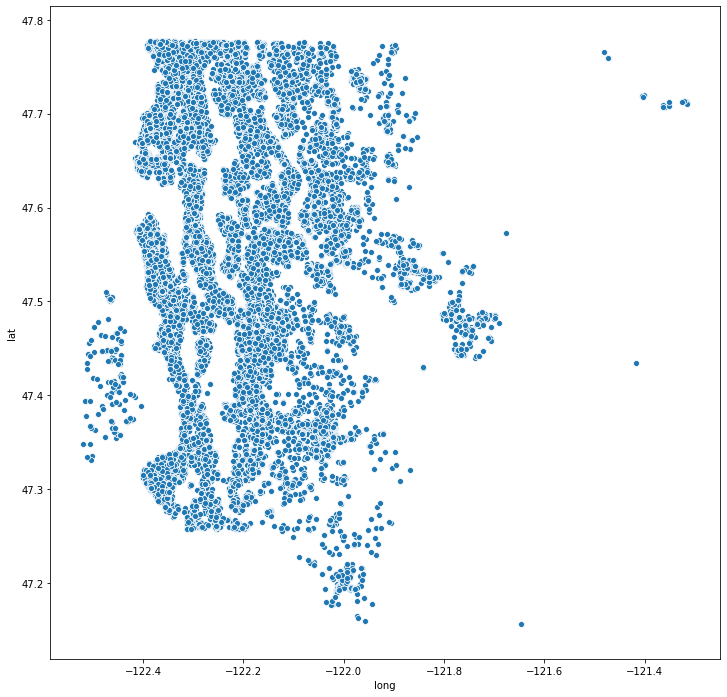

In [8]:
plt.figure(figsize=(12, 12))
ax = sns.scatterplot(x='long', y='lat', data=df_kc)

## Model: K-means

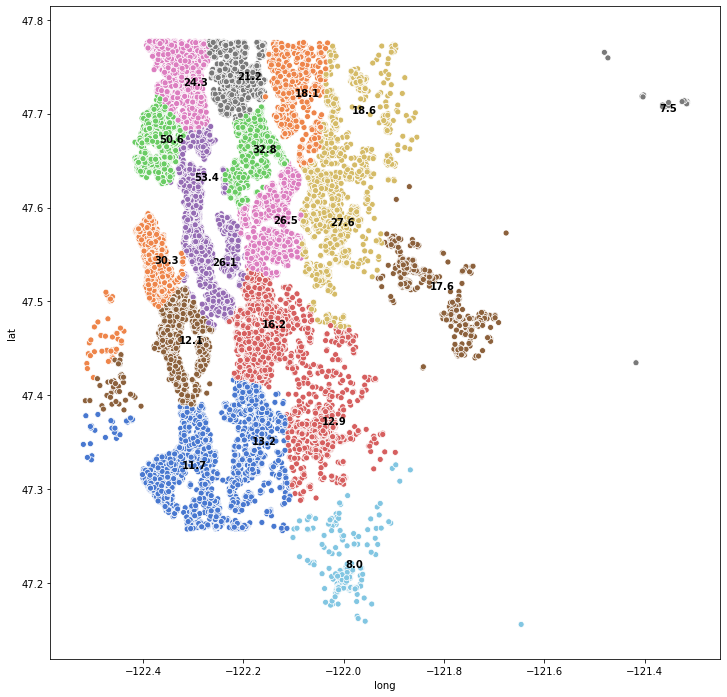

In [9]:
N_clusters = 19
KMC_KC = KMeans(n_clusters = N_clusters)
KMC_KC.fit(df_kc[['long','lat']])
KMC_KC_pred = KMC_KC.predict(df_kc[['long','lat']])
df_kc['cluster'] = KMC_KC_pred  

plt.figure(figsize=(12, 12))

ax = sns.scatterplot(x='long', y='lat', hue='cluster', 
                     palette=sns.color_palette("muted", n_colors=N_clusters), 
                     legend = False,
                     data=df_kc)
for i in df_kc['cluster'].unique():
    df_average = df_kc[df_kc['cluster'] == i].mean()
    ax.text(df_average['long'], df_average['lat'], str(df_average['unit_price'].round(1)), 
            horizontalalignment='left', size='medium', weight='semibold')
plt.savefig('KC_KM.png',dpi=600) 

## Model: Birch

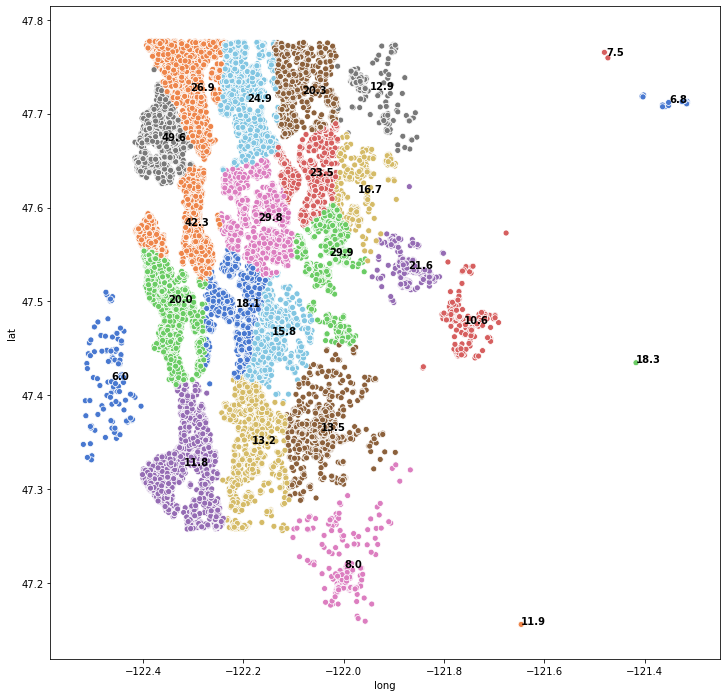

In [10]:
MSC_KC = Birch(branching_factor=50, n_clusters=None, threshold=0.06, compute_labels=True)
MSC_KC.fit(df_kc[['long','lat']])
MSC_KC_pred = MSC_KC.predict(df_kc[['long','lat']])
df_kc['cluster1'] = MSC_KC_pred  

plt.figure(figsize=(12, 12))

ax = sns.scatterplot(x='long', y='lat', hue='cluster1', 
                     palette=sns.color_palette("muted", n_colors=len(df_kc['cluster1'].unique())), 
                     legend = False,
                     data=df_kc)
for i in df_kc['cluster1'].unique():
    df_average = df_kc[df_kc['cluster1'] == i].mean()
    ax.text(df_average['long'], df_average['lat'], str(df_average['unit_price'].round(1)), 
            horizontalalignment='left', size='medium', weight='semibold')
plt.savefig('KC_Birch.png',dpi=600) 

The Birch result seems more reasonable compared to K-means result on KC data, where we pick the number of clusters randomly.